In [24]:
# 1. Import Libraries
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, Audio
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import evaluate

In [25]:
# 2. Load Models
MODEL_BASE = "../models/whisper_tiny_de"
MODEL_FT = "../models/whisper_tiny_de_finetuned"

processor = WhisperProcessor.from_pretrained(MODEL_BASE)
model_base = WhisperForConditionalGeneration.from_pretrained(MODEL_BASE).to("mps")
model_ft = WhisperForConditionalGeneration.from_pretrained(MODEL_FT).to("mps")

In [26]:
# 3. Load Dataset (Common Voice German – nhỏ để test)
common_voice = load_dataset(
    "mozilla-foundation/common_voice_13_0",
    "de",
    split="test[:1%]"  # chỉ 1% để chạy nhanh
)
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))
print(common_voice[0])

{'client_id': '0052c07533a6976233ad5926d950b523002c4d8cdd9ae8726dbfec385951bd22aa707a742c49afe20c7d6cb9515dbaddac5b4d6fe8ebddcfbec46a2d3180a3a1', 'path': '/Users/vietphung/.cache/huggingface/datasets/downloads/extracted/ccc7b257eee0ae4c1d6e33545d2e70a289a88ee542f249aeccee5ffe2b8710ae/de_test_0/common_voice_de_17922420.mp3', 'audio': {'path': '/Users/vietphung/.cache/huggingface/datasets/downloads/extracted/ccc7b257eee0ae4c1d6e33545d2e70a289a88ee542f249aeccee5ffe2b8710ae/de_test_0/common_voice_de_17922420.mp3', 'array': array([-1.20792265e-13,  8.88178420e-15, -7.81597009e-14, ...,
        1.40588030e-09, -3.40380302e-09,  1.92106775e-10]), 'sampling_rate': 16000}, 'sentence': 'Zieht euch bitte draußen die Schuhe aus.', 'up_votes': 2, 'down_votes': 0, 'age': '', 'gender': '', 'accent': '', 'locale': 'de', 'segment': '', 'variant': ''}


In [27]:
# 4. Define Evaluation Function
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

def evaluate_model(model, processor, dataset, num_samples=50):
    """
    Evaluate model on WER, CER using a subset of dataset.
    """
    refs, preds = [], []
    for i, ex in enumerate(dataset.select(range(num_samples))):
        audio = ex["audio"]["array"]
        inputs = processor(
            audio,
            sampling_rate=16000,
            return_tensors="pt"
        ).to("mps")

        with torch.no_grad():
            generated_ids = model.generate(
                inputs.input_features,
                generation_config=model.generation_config
            )
        pred = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        refs.append(ex["sentence"])
        preds.append(pred)

    wer = wer_metric.compute(predictions=preds, references=refs)
    cer = cer_metric.compute(predictions=preds, references=refs)
    return wer, cer, preds[:5], refs[:5]

In [28]:
# 5. Run Evaluation (Base Model)
wer_base, cer_base, preds_base, refs_base = evaluate_model(model_base, processor, common_voice)

print("=== Base Model ===")
print(f"WER: {wer_base:.4f}")
print(f"CER: {cer_base:.4f}")
print("\nExamples:")
for r, p in zip(refs_base, preds_base):
    print(f"REF: {r}\nPRED: {p}\n")

=== Base Model ===
WER: 0.9721
CER: 0.4806

Examples:
REF: Zieht euch bitte draußen die Schuhe aus.
PRED:  Sieht euch bitte draußen die Schuhe aus.

REF: Es gibt auch mehrere Campingplätze.
PRED:  Päskelt auch mehr Ergämpfe in Plätze.

REF: Als Kind wollte er nach eigenen Aussagen Footballspieler werden.
PRED:  Als Kind wurde nach Einen aus Sagenfutburg-Spieler werden.

REF: Es kommt zum Showdown in Gstaad.
PRED:  Das kommt runter.

REF: Ihre Fotostrecken erschienen in Modemagazinen wie der Vogue, Harper’s Bazaar und Marie Claire.
PRED:  Die Defurtusträgen ja schienen den Monabagantien mit der Rauke, hat das Bazar der Riker.



In [29]:
# 6. Run Evaluation (Fine-Tuned Model)
wer_ft, cer_ft, preds_ft, refs_ft = evaluate_model(model_ft, processor, common_voice)

print("=== Fine-Tuned Model ===")
print(f"WER: {wer_ft:.4f}")
print(f"CER: {cer_ft:.4f}")
print("\nExamples:")
for r, p in zip(refs_ft, preds_ft):
    print(f"REF: {r}\nPRED: {p}\n")

=== Fine-Tuned Model ===
WER: 0.4628
CER: 0.2086

Examples:
REF: Zieht euch bitte draußen die Schuhe aus.
PRED:  zieht euch bitte draußen die Schuhe aus.

REF: Es gibt auch mehrere Campingplätze.
PRED:  Päs geht auch mehrere Gewinplätze.

REF: Als Kind wollte er nach eigenen Aussagen Footballspieler werden.
PRED:  Als Kind wurde er nach eigenen Aussagen fortburspieler werden.

REF: Es kommt zum Showdown in Gstaad.
PRED:  Es kommt und verankt.

REF: Ihre Fotostrecken erschienen in Modemagazinen wie der Vogue, Harper’s Bazaar und Marie Claire.
PRED:  Ihre Fotosträgen erschienen eine Monomariziehen mit der Rauk-Hartensbersar-Wahrriker.



In [30]:
# 7. Compare Results in Table
df = pd.DataFrame({
    "Model": ["Base", "Fine-tuned"],
    "WER": [wer_base, wer_ft],
    "CER": [cer_base, cer_ft]
})
display(df)

,Model,WER,CER
0,Base,0.972093,0.480599
1,Fine-tuned,0.462791,0.208645


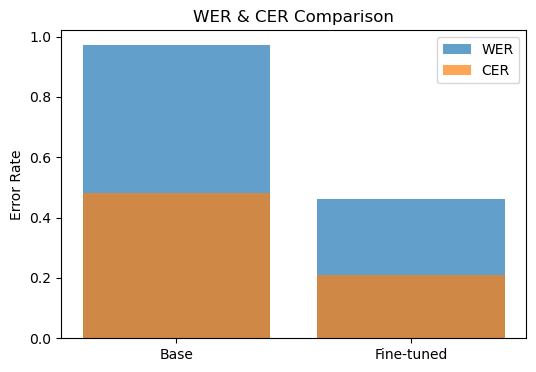

In [31]:
plt.figure(figsize=(6,4))
plt.bar(df["Model"], df["WER"], label="WER", alpha=0.7)
plt.bar(df["Model"], df["CER"], label="CER", alpha=0.7)
plt.ylabel("Error Rate")
plt.title("WER & CER Comparison")
plt.legend()
plt.show()